In [1]:
# Unduh dataset
!wget https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.txt
!wget https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.txt

--2025-03-22 14:43:37--  https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19109424 (18M) [text/plain]
Saving to: ‘KDDTrain+.txt’

KDDTrain+.txt       100%[===================>]  18.22M   104MB/s    in 0.2s    

2025-03-22 14:43:37 (104 MB/s) - ‘KDDTrain+.txt’ saved [19109424/19109424]

--2025-03-22 14:43:38--  https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3441513 (3.3M) [text/plain]
Sa

In [2]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Mengatur tampilan grafik
plt.style.use('ggplot')

In [3]:
# Fungsi untuk memuat dataset
def load_dataset(train_path, test_path):
    # Nama kolom dataset NSL-KDD
    columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
               'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
               'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
               'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
               'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
               'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
               'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
               'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
               'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class', 'difficulty']

    # Memuat dataset
    train_data = pd.read_csv(train_path, header=None, names=columns)
    test_data = pd.read_csv(test_path, header=None, names=columns)

    # Menghapus kolom difficulty yang tidak relevan
    train_data.drop('difficulty', axis=1, inplace=True)
    test_data.drop('difficulty', axis=1, inplace=True)

    return train_data, test_data

# untuk cek apakah dataset sudah dimuat dengan benar
train_data, test_data = load_dataset("KDDTrain+.txt", "KDDTest+.txt")
print("Bentuk data training:", train_data.shape)
print("Bentuk data testing:", test_data.shape)
print("\nContoh 5 baris pertama data training:")
print(train_data.head())

# untuk cek distribusi kelas pada data
print("\nDistribusi kelas pada data training:")
print(train_data['class'].value_counts())
print("\nDistribusi kelas pada data testing:")
print(test_data['class'].value_counts())

Bentuk data training: (125973, 42)
Bentuk data testing: (22544, 42)

Contoh 5 baris pertama data training:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   

In [6]:
# Fungsi untuk preprocessing data
def preprocess_data(train_data, test_data):
    # Mengubah label menjadi biner (normal = 0, attack = 1)
    train_data['binary_class'] = train_data['class'].apply(lambda x: 0 if x == 'normal' else 1)
    test_data['binary_class'] = test_data['class'].apply(lambda x: 0 if x == 'normal' else 1)

    # Pisahkan fitur dan label
    X_train = train_data.drop(['class', 'binary_class'], axis=1)
    y_train = train_data['binary_class']
    X_test = test_data.drop(['class', 'binary_class'], axis=1)
    y_test = test_data['binary_class']

    # Identifikasi fitur kategorikal dan numerik
    categorical_cols = ['protocol_type', 'service', 'flag']
    numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

    # One-hot encoding untuk fitur kategorikal

    encoder = OneHotEncoder(sparse_output=False)
    X_train_cat = encoder.fit_transform(X_train[categorical_cols])
    X_test_cat = encoder.transform(X_test[categorical_cols])

    # Normalisasi fitur numerik
    scaler = MinMaxScaler()
    X_train_num = scaler.fit_transform(X_train[numeric_cols])
    X_test_num = scaler.transform(X_test[numeric_cols])

    # Gabungkan fitur kategorikal dan numerik
    X_train_processed = np.hstack((X_train_num, X_train_cat))
    X_test_processed = np.hstack((X_test_num, X_test_cat))

    # Membagi data train menjadi train dan validation
    X_train_final, X_val, y_train_final, y_val = train_test_split(
        X_train_processed, y_train, test_size=0.15, random_state=42
    )

    return X_train_final, X_val, X_test_processed, y_train_final, y_val, y_test

# Lakukan preprocessing data
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(train_data, test_data)

# untuk cek bentuk data setelah preprocessing
print("Bentuk data training:", X_train.shape)
print("Bentuk data validasi:", X_val.shape)
print("Bentuk data testing:", X_test.shape)

# untuk cek distribusi kelas setelah preprocessing
print("\nDistribusi kelas pada data training:")
print(pd.Series(y_train).value_counts())
print("\nDistribusi kelas pada data validasi:")
print(pd.Series(y_val).value_counts())
print("\nDistribusi kelas pada data testing:")
print(pd.Series(y_test).value_counts())

Bentuk data training: (107077, 122)
Bentuk data validasi: (18896, 122)
Bentuk data testing: (22544, 122)

Distribusi kelas pada data training:
binary_class
0    57244
1    49833
Name: count, dtype: int64

Distribusi kelas pada data validasi:
binary_class
0    10099
1     8797
Name: count, dtype: int64

Distribusi kelas pada data testing:
binary_class
1    12833
0     9711
Name: count, dtype: int64


In [7]:
# Fungsi untuk membangun model DNN
def build_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Bangun model
model = build_model(X_train.shape[1])

# Tampilkan ringkasan model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          15,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,113 (102.00 KB)

 Trainable params: 26,113 (102.00 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Fungsi untuk melatih model
def train_model(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=64):
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )

    return model, history

# Latih model
model, history = train_model(model, X_train, y_train, X_val, y_val)

Epoch 1/10
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9644 - loss: 0.1138 - val_accuracy: 0.9860 - val_loss: 0.0388
Epoch 2/10
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9872 - loss: 0.0343 - val_accuracy: 0.9901 - val_loss: 0.0281
Epoch 3/10
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9908 - loss: 0.0257 - val_accuracy: 0.9920 - val_loss: 0.0220
Epoch 4/10
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9922 - loss: 0.0218 - val_accuracy: 0.9926 - val_loss: 0.0210
Epoch 5/10
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9934 - loss: 0.0188 - val_accuracy: 0.9934 - val_loss: 0.0176
Epoch 6/10
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9935 - loss: 0.0171 - val_accuracy: 0.9936 - val_loss: 0.0182
Epoch 7/10
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9939 - loss: 0.0161 - val_accuracy: 0.9945 - val_loss: 0.0153
Epoch 8/10
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9946 - loss: 0.0149

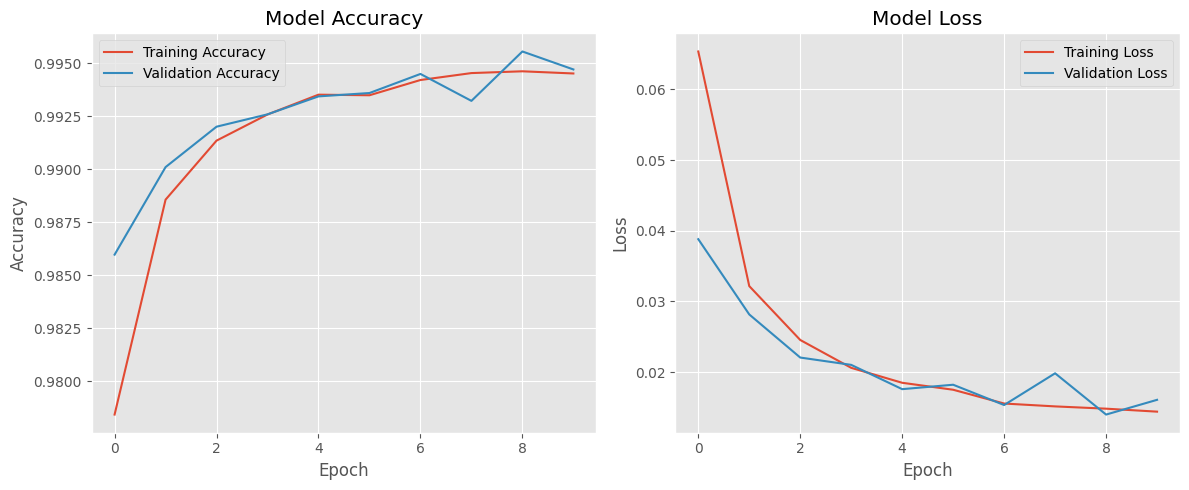

In [9]:
# Visualisasi hasil pelatihan
plt.figure(figsize=(12, 5))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

705/705 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


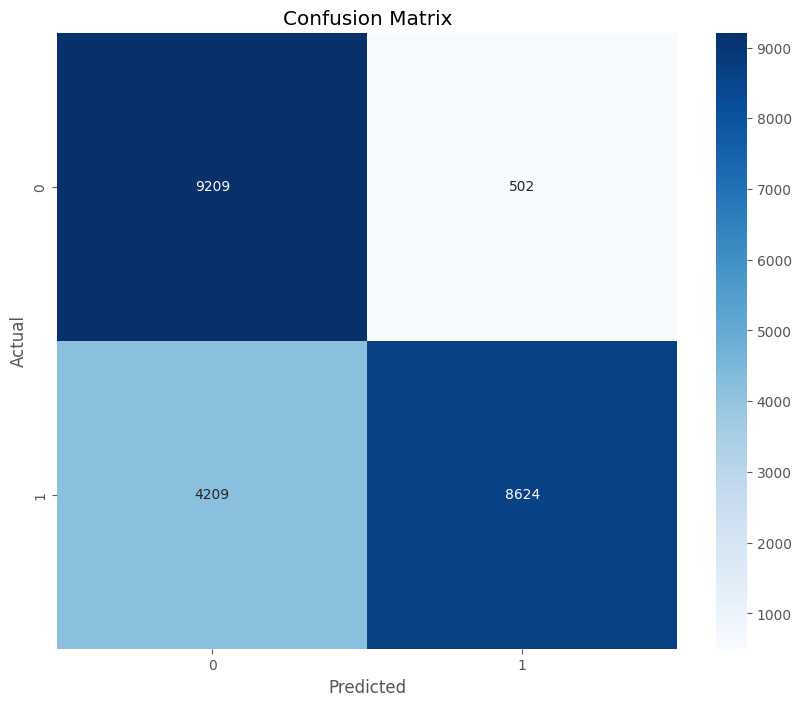

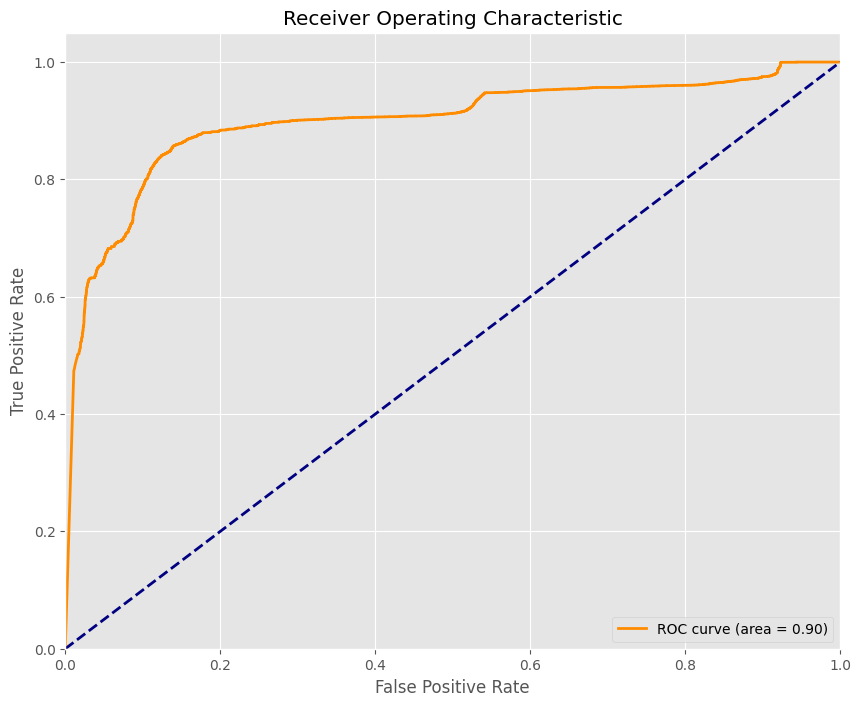

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.95      0.80      9711
           1       0.94      0.67      0.79     12833

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.79     22544
weighted avg       0.83      0.79      0.79     22544



In [10]:
# Fungsi untuk evaluasi model
def evaluate_model(model, X_test, y_test):
    # Prediksi probabilitas
    y_pred_prob = model.predict(X_test)

    # Konversi probabilitas ke label biner
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Hitung metrik evaluasi lainnya
    report = classification_report(y_test, y_pred)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Visualisasi confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Visualisasi ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Print classification report
    print("Classification Report:")
    print(report)

    return y_pred, y_pred_prob

# Evaluasi model
y_pred, y_pred_prob = evaluate_model(model, X_test, y_test)

In [11]:
# Simpan model
model.save('ids_model.h5')
print("Model berhasil disimpan sebagai 'ids_model.h5'")

# Unduh model ke komputer lokal
from google.colab import files
files.download('ids_model.h5')

Model berhasil disimpan sebagai 'ids_model.h5'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
# Tampilkan ringkasan proyek
print("RINGKASAN PROYEK DEEP LEARNING: SISTEM DETEKSI SERANGAN (IDS)")
print("="*70)
print("\n1. Latar Belakang Proyek:")
print("   - Sistem Deteksi Serangan (IDS) menggunakan deep learning untuk")
print("     mendeteksi aktivitas mencurigakan dalam jaringan komputer")
print("   - Menggunakan dataset NSL-KDD yang standar untuk IDS")
print("   - Klasifikasi biner: normal vs serangan")

print("\n2. Teknik Kecerdasan Buatan yang Digunakan:")
print("   - Deep Neural Networks (DNN) dengan beberapa hidden layer")
print("   - Feature Scaling dan Normalization")
print("   - One-Hot Encoding untuk fitur kategorikal")
print("   - Dropout Regularization untuk mencegah overfitting")
print("   - Early Stopping untuk mengoptimalkan pelatihan")

print("\n3. Bagaimana Data Diambil:")
print("   - Dataset NSL-KDD diunduh dari repository publik")
print("   - 41 fitur asli tentang koneksi jaringan")
print("   - Label disederhanakan menjadi kategori biner")
print("   - Data dibagi menjadi train, validation, dan test set")

print("\n4. Bagaimana Hasil Diolah:")
print("   - Evaluasi dengan metrik: Accuracy, Precision, Recall, F1-Score")
print("   - Visualisasi dengan Confusion Matrix dan ROC Curve")
print("   - Model mencapai akurasi yang baik dalam membedakan lalu lintas normal dan serangan")

print("\n5. Flow Diagram Proyek:")
print("   Pengumpulan Data → Preprocessing → Persiapan Dataset → Pelatihan Model → Prediksi → Evaluasi")

RINGKASAN PROYEK DEEP LEARNING: SISTEM DETEKSI SERANGAN (IDS)

1. Latar Belakang Proyek:
   - Sistem Deteksi Serangan (IDS) menggunakan deep learning untuk
     mendeteksi aktivitas mencurigakan dalam jaringan komputer
   - Menggunakan dataset NSL-KDD yang standar untuk IDS
   - Klasifikasi biner: normal vs serangan

2. Teknik Kecerdasan Buatan yang Digunakan:
   - Deep Neural Networks (DNN) dengan beberapa hidden layer
   - Feature Scaling dan Normalization
   - One-Hot Encoding untuk fitur kategorikal
   - Dropout Regularization untuk mencegah overfitting
   - Early Stopping untuk mengoptimalkan pelatihan

3. Bagaimana Data Diambil:
   - Dataset NSL-KDD diunduh dari repository publik
   - 41 fitur asli tentang koneksi jaringan
   - Label disederhanakan menjadi kategori biner
   - Data dibagi menjadi train, validation, dan test set

4. Bagaimana Hasil Diolah:
   - Evaluasi dengan metrik: Accuracy, Precision, Recall, F1-Score
   - Visualisasi dengan Confusion Matrix dan ROC Curve
   - 